In [1]:
import gc
import os

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.nn import PyroModule, PyroSample
from pyro.optim import Adam
from scipy.stats import norm

from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument, compute_freq
from qubic.lib.MapMaking.FrequencyMapMaking.Qspectra_component import CMBModel
from qubic.lib.MapMaking.NeuralNetworkMapMaking.operators.forward_ops import ForwardOps
from qubic.lib.Qdictionary import qubicDict
from qubic.lib.Qsamplings import equ2gal, get_pointing
from qubic.lib.Qscene import QubicScene

In [2]:
%matplotlib inline

# QUBIC Parameters

In [3]:
dictfilename = "qubic/qubic/dicts/pipeline_demo.dict"
d = qubicDict()
d.read_from_file(dictfilename)

center = equ2gal(d["RA_center"], d["DEC_center"])

In [4]:
d["nf_recon"] = 1
d["MultiBand"] = False
d["synthbeam_kmax"] = 1
nf_sub = d["nf_sub"]
d["synthbeam_fraction"] = 1
d["noiseless"] = True
d["photon_noise"] = False
d["use_synthbeam_fits_file"] = False
d["npointings"] = 1000
d["nside"] = 128

# Build Sky

In [5]:
seed = 3
sky_config = {"cmb": seed}
cl_cmb = CMBModel(None).give_cl_cmb(r=0, Alens=1)
sky_map = np.array(d["nf_sub"] * [hp.synfast(cl_cmb, d["nside"], new=True, verbose=False).T])[0]
print(sky_map.shape)

(196608, 3)


# QUBIC Instance

In [6]:
p = get_pointing(d)
s = QubicScene(d)
q = QubicInstrument(d)
acquisition = QubicAcquisition(q, p, s, d)

_, nus_edge, nus, _, _, _ = compute_freq(d["filter_nu"] / 1e9, d["nf_sub"], d["filter_relative_bandwidth"])

In [7]:
H = acquisition.get_operator()
convolution = acquisition.get_convolution_peak_operator()
convolved_maps = convolution(sky_map)
cov = acquisition.get_coverage()

Info apcnb2325: Allocating (992000,9) elements = 136.23046875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (992000,9) elements = 136.23046875 MiB in FSRRotation3dMatrix.__init__.


In [8]:
forward_ops = ForwardOps(q, acquisition, s)

# Sequential Operators combinations for training

In [9]:
Us = forward_ops.op_unit_conversion()(convolved_maps)

TUs = Us

ATUs = forward_ops.op_aperture_integration()(TUs)

FATUs = forward_ops.op_filter()(ATUs)
print(FATUs.shape)

(196608, 3)


In [10]:
PFATUs = H.operands[-1](FATUs)
print(PFATUs.shape)

HPFATUs = forward_ops.op_hwp()(PFATUs)
PHPFATUs = forward_ops.op_polarizer()(HPFATUs)
print(PHPFATUs.shape)

APHPFATUs = forward_ops.op_detector_integration()(PHPFATUs)
TAPHPFATUs = forward_ops.op_transmission()(APHPFATUs)
RTAPHPFATUs = forward_ops.op_bolometer_response()(TAPHPFATUs)

(992, 1000, 3)
(992, 1000)


## Apply the transmission operator to a TOD to get both datasets (before-after application)

In [11]:
transmission_operator = forward_ops.op_transmission()

# original_tod = torch.randn(num_detectors, num_pointings, dtype=torch.float32)
original_tod = torch.tensor(APHPFATUs, dtype=torch.float64)

tod_after_transmission = torch.tensor(transmission_operator(original_tod.detach().cpu().numpy()), dtype=torch.float64)

In [12]:
tod_before_transmission_list = []
tod_after_transmission_list = []
q.detector.efficiency = np.ones(q.detector.efficiency.shape, dtype=np.float64)
q.detector.efficiency[:] = 0.5
for i in range(5):
    original_tod = APHPFATUs
    tod_before_transmission_list.append(original_tod)
    tod_after_transmission = transmission_operator(original_tod)
    tod_after_transmission_list.append(tod_after_transmission)

new_eff = np.ones(q.detector.efficiency.shape, dtype=np.float64)
new_eff[:] = 0.1
q.detector.efficiency = new_eff
for i in range(5):
    transmission_operator = forward_ops.op_transmission()
    original_tod = APHPFATUs
    tod_before_transmission_list.append(original_tod)
    tod_after_transmission = transmission_operator(original_tod)
    tod_after_transmission_list.append(tod_after_transmission)

tod_before_transmission_torch = torch.tensor(tod_before_transmission_list, dtype=torch.float64)
tod_after_transmission_torch = torch.tensor(tod_after_transmission_list, dtype=torch.float64)

# Monochromatic Pyro example for transmission:

In [13]:
pyro.set_rng_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"

# N is batch, D is detectrs (992), Nt is time samples
det_tod = tod_after_transmission_torch.to(torch.float32).to(device)  # shape (N,D,Nt)
sky_tod = tod_before_transmission_torch.to(torch.float32).to(device)  # same shape
N, D, Nt = det_tod.shape  # D=992


class InvEtaPerSample(PyroModule):
    def __init__(self, rel_sigma=0.05):
        super().__init__()
        self.log_eta = PyroSample(dist.Normal(0.0, rel_sigma))

    def forward(self, tod_det):  # tod_det : (N, D, Nt)
        eta = torch.exp(self.log_eta)  # (N
        eta = eta[:, None, None]  # (N, 1, 1)   over det & time
        return tod_det / eta  # undo thru


layer = InvEtaPerSample(rel_sigma=0.20).to(device)  # 20 % width prior

sigma_noise = 1e-18  # assumed white noise add a small value


def model(det, sky):
    with pyro.plate("batch", det.size(0)):  # one eta per sample
        sky_hat = layer(det)
        pyro.sample("obs", dist.Normal(sky_hat, sigma_noise).to_event(2), obs=sky)


Optimizer, guide, and SVI

In [14]:
guide = pyro.infer.autoguide.AutoNormal(model)

optim = Adam({"lr": 3e-3})

svi = SVI(model, guide, optim, Trace_ELBO())

In [15]:
ckpt_file = "invT_svi_ckpt.pt"
save_every = 20  # how often to checkpoint
n_steps = 400  # total extra stepst to run

In [16]:
start = 200

In [17]:
# this is just if you want to train in multiple times, to save the checkppoint and continue, since pyro can be memory expensive
if os.path.exists(ckpt_file):
    ckpt = torch.load(ckpt_file, map_location=device, weights_only=False)
    pyro.get_param_store().set_state(ckpt["param_store"])
    optim.set_state(ckpt["optim_state"])
    start = ckpt["step"] + 1
    print(f"✓ Resuming from step {start}")


for step in range(start, start + n_steps):
    loss = svi.step(det_tod, sky_tod)

    if step % save_every == 0:
        torch.save(
            {
                "step": step,
                "param_store": pyro.get_param_store().get_state(),
                "optim_state": optim.get_state(),
            },
            ckpt_file,
        )
        print(f"step {step:5d} | ELBO {loss:8.3g}  ➜ checkpoint saved")

print("Done ✔")

✓ Resuming from step 581
step   600 | ELBO -3.74e+08  ➜ checkpoint saved
step   620 | ELBO -3.76e+08  ➜ checkpoint saved
step   640 | ELBO -3.81e+08  ➜ checkpoint saved
step   660 | ELBO -3.8e+08  ➜ checkpoint saved
step   680 | ELBO -3.82e+08  ➜ checkpoint saved
step   700 | ELBO -3.84e+08  ➜ checkpoint saved
step   720 | ELBO -3.88e+08  ➜ checkpoint saved
step   740 | ELBO -3.9e+08  ➜ checkpoint saved
step   760 | ELBO -3.92e+08  ➜ checkpoint saved
step   780 | ELBO -3.95e+08  ➜ checkpoint saved
step   800 | ELBO -3.96e+08  ➜ checkpoint saved
step   820 | ELBO -3.99e+08  ➜ checkpoint saved
step   840 | ELBO   -4e+08  ➜ checkpoint saved
step   860 | ELBO   -4e+08  ➜ checkpoint saved
step   880 | ELBO   -4e+08  ➜ checkpoint saved
step   900 | ELBO -4.01e+08  ➜ checkpoint saved
step   920 | ELBO   -4e+08  ➜ checkpoint saved
step   940 | ELBO -4.01e+08  ➜ checkpoint saved
step   960 | ELBO -4.01e+08  ➜ checkpoint saved
step   980 | ELBO -4.02e+08  ➜ checkpoint saved
Done ✔


In [18]:
if True:
    n_steps = 10
    for step in range(1, n_steps + 1):
        loss = svi.step(det_tod, sky_tod)
        if step % 20 == 0:
            print(f"SVI step {step:4d}  ELBO = {loss:.3g}")

In [19]:
predictive = Predictive(model, guide=guide, num_samples=50, return_sites=["log_eta"])
post = predictive(det_tod, sky=None)
eta_samples = torch.exp(post["log_eta"])  # (300 , N)

eta_mean = eta_samples.mean(0).cpu()  # (N,)
eta_std = eta_samples.std(0).cpu()

print(eta_mean)

tensor([0.5037, 0.5125, 0.5022, 0.4979, 0.5026, 0.0626, 0.0672, 0.0657, 0.0641,
        0.0650])


SAMPLE  0  η = 0.504 ± 0.025
SAMPLE  1  η = 0.512 ± 0.023
SAMPLE  2  η = 0.502 ± 0.029
SAMPLE  3  η = 0.498 ± 0.026
SAMPLE  4  η = 0.503 ± 0.027
SAMPLE  5  η = 0.063 ± 0.005
SAMPLE  6  η = 0.067 ± 0.009
SAMPLE  7  η = 0.066 ± 0.007
SAMPLE  8  η = 0.064 ± 0.005
SAMPLE  9  η = 0.065 ± 0.006


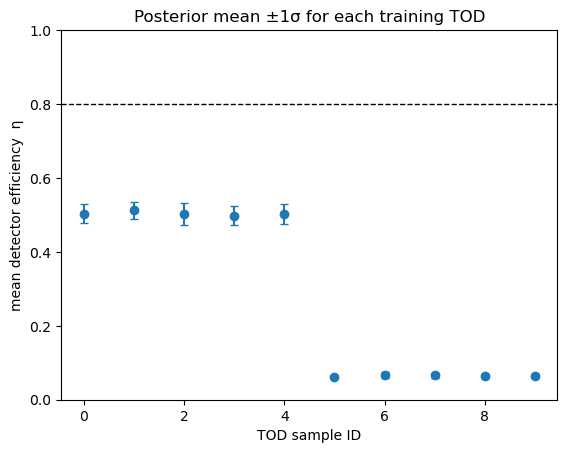

In [20]:
for i, (m, s) in enumerate(zip(eta_mean, eta_std)):
    print(f"SAMPLE {i:2d}  η = {m:.3f} ± {s:.3f}")

plt.figure()
plt.errorbar(range(N), eta_mean, yerr=eta_std, fmt="o", capsize=3, color="tab:blue")
# plt.axhline(0.7, ls='--', c='k', lw=1)
plt.axhline(0.8, ls="--", c="k", lw=1)
plt.ylabel("mean detector efficiency  η")
plt.xlabel("TOD sample ID")
plt.ylim(0.0, 1.0)
plt.title("Posterior mean ±1σ for each training TOD")
plt.show()

This is enough to get a mean efficiency and the error.
To look at the posterior and interpret it we need to draw samples.

# Drawing samples

In [21]:
def posterior_mean_std_and_samples(model, guide, det_tod, n_draw=60, chunk=10, sample_site="log_eta", keep_draws=False):
    """
    Same as before, but optionally returns a tensor of all stored draws.
    Set keep_draws=True if you want to keep them (this may be large! depends on the choice of size of sempling sets!).
    """
    assert n_draw % chunk == 0
    mean = m2 = None
    n_seen = 0
    all_draws = [] if keep_draws else None

    pred = Predictive(model, guide=guide, num_samples=chunk, return_sites=[sample_site])

    for _ in range(n_draw // chunk):
        post = pred(det_tod, sky=None)
        draws = torch.exp(post[sample_site]).mean(1)  # (chunk, N_det)

        if keep_draws:
            all_draws.append(draws.cpu())

        for x in draws:
            n_seen += 1
            if mean is None:
                mean = torch.zeros_like(x)
                m2 = torch.zeros_like(x)
            delta = x - mean
            mean += delta / n_seen
            m2 += delta * (x - mean)

        del post, draws

    std = torch.sqrt(m2 / (n_seen - 1))
    if keep_draws:
        all_draws = torch.cat(all_draws, dim=0)  # (n_draw, N_det)
        return mean.cpu(), std.cpu(), all_draws
    return mean.cpu(), std.cpu()

In [22]:
eta_mean, eta_std, eta_samples = posterior_mean_std_and_samples(model, guide, det_tod, n_draw=300, chunk=10, keep_draws=True)

In [23]:
if False:
    predictive = Predictive(model, guide=guide, num_samples=50, return_sites=["log_eta"])
    post = predictive(det_tod, sky=None)
    eta_samples = torch.exp(post["log_eta"])  # (300 , N)

    eta_mean = eta_samples.mean(0).cpu()  # (N,)
    eta_std = eta_samples.std(0).cpu()

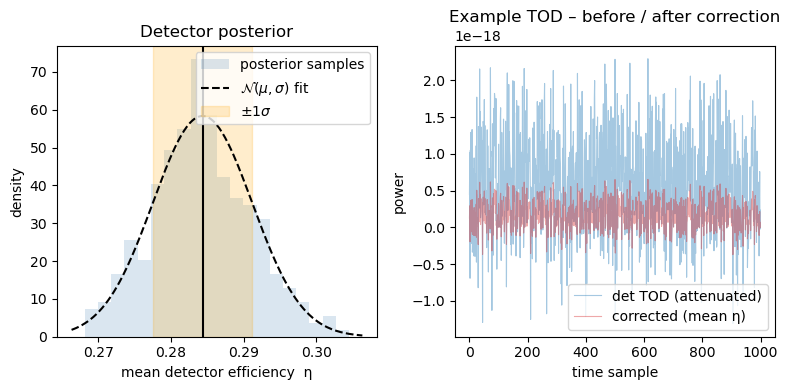

In [24]:
det_id = 0

invT_det = eta_samples[:,].cpu()  # ,)

# posterior mean / std for this detector
mu_det = eta_samples.mean().item()
sig_det = eta_samples.std().item()


tod_det = det_tod[0, det_id].cpu()  # shape (Nt,)
tod_corr = tod_det * mu_det  # a point-estimate correction
tod_true = sky_tod[0, det_id].cpu()

Nt = tod_det.numel()
t = np.arange(Nt)  # over time samples


fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(eta_samples[:].numpy(), bins=20, alpha=0.2, color="steelblue", density=True, label="posterior samples")

xmin, xmax = ax[0].get_xlim()
xs = np.linspace(xmin, xmax, 200)
ax[0].plot(xs, norm.pdf(xs, mu_det, sig_det), "k--", label=r"$\mathcal{N}(\mu,\sigma)$ fit")
ax[0].axvline(mu_det, color="k")
ax[0].axvspan(mu_det - sig_det, mu_det + sig_det, alpha=0.2, color="orange", label=r"$\pm1\sigma$")
ax[0].set_xlabel(r"mean detector efficiency  η")
ax[0].set_ylabel("density")
ax[0].set_title("Detector posterior")
ax[0].legend()

ax[1].plot(t, tod_det, lw=0.8, label="det TOD (attenuated)", alpha=0.4)
ax[1].plot(t, tod_corr, lw=0.8, label="corrected (mean η)", color="C3", alpha=0.4)
# ax[1].plot(t, tod_true, '--', lw=1.0, label='sky TOD (target)',  color='k', alpha = 0.4)
ax[1].set_xlabel("time sample")
ax[1].set_ylabel("power")
ax[1].set_title("Example TOD – before / after correction")
ax[1].legend()

plt.tight_layout()
plt.show()


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

det_tod = tod_after_transmission_torch.to(torch.float32).to(device)
sky_tod = tod_before_transmission_torch.to(torch.float32).to(device)

N, D, Nt = det_tod.shape  # tribalo bi bit 10, 992, 8000


class InvT_perSample(PyroModule):
    def __init__(self, T_optics, rel_sigma=0.05):
        super().__init__()
        loc = torch.tensor(np.log(1.0))  # prior around 1 over T
        scale = torch.tensor(rel_sigma)

        self.log_invT = PyroSample(dist.Normal(loc, scale))

        self.T_optics = torch.tensor(T_optics, dtype=torch.float32)

    def forward(self, tod_det):
        invT = torch.exp(self.log_invT)  # shape (N,)
        # broadcast: (N,1,1) * (N,992,Nt)
        return tod_det * invT[:, None, None] / self.T_optics


T_optics = float(np.prod(q.optics.components["transmission"]))
layer = InvT_perSample(T_optics, rel_sigma=0.10).to(device)


def model(det, sky):
    with pyro.plate("batch", det.size(0)):
        sky_hat = layer(det)
        pyro.sample("obs", dist.Normal(sky_hat, sigma_noise).to_event(2), obs=sky)


guide = pyro.infer.autoguide.AutoNormal(model)
optim = Adam({"lr": 2e-3})
svi = SVI(model, guide, optim, Trace_ELBO())

n_steps = 200
for step in range(n_steps):
    loss = svi.step(det_tod, sky_tod)
    if step % 20 == 0:
        print(f"SVI step {step:4d} | ELBO {loss:.4g}")

SVI step    0 | ELBO -3.559e+08
SVI step   20 | ELBO -3.565e+08
SVI step   40 | ELBO -3.575e+08
SVI step   60 | ELBO -3.58e+08
SVI step   80 | ELBO -3.594e+08
SVI step  100 | ELBO -3.592e+08
SVI step  120 | ELBO -3.607e+08
SVI step  140 | ELBO -3.61e+08
SVI step  160 | ELBO -3.604e+08
SVI step  180 | ELBO -3.624e+08


In [26]:
predictive = Predictive(model, guide=guide, num_samples=50)
post = predictive(det_tod, sky=None)

print("available sites:", list(post.keys()))

available sites: ['log_invT', 'obs']


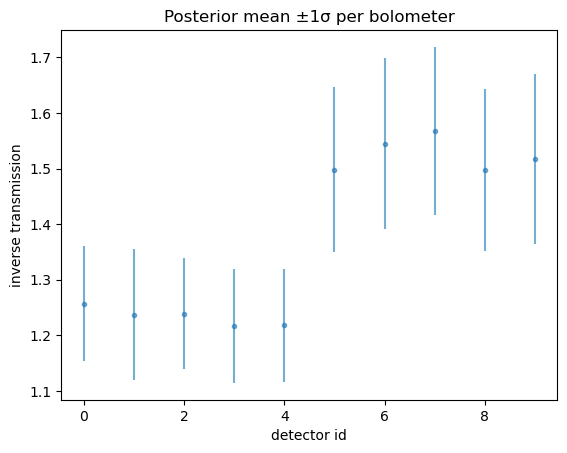

In [27]:
invT_samples = torch.exp(post["log_invT"])

mean = invT_samples.mean(0).cpu()
std = invT_samples.std(0).cpu()

plt.errorbar(range(len(mean)), mean, yerr=std, fmt=".", alpha=0.6)
plt.xlabel("detector id")
plt.ylabel("inverse transmission")
plt.title("Posterior mean ±1σ per bolometer")
plt.show()

Global inverse-throughput  = 1.3790 ± 0.0426
Estimated efficiency η     = 1 / (T_optics * invT)


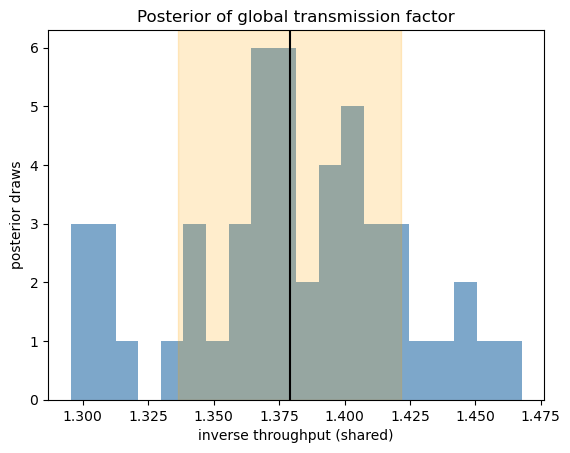

In [28]:
invT_samples = invT_samples.squeeze()

# u ovom slucaju izjednacujemo preko svih uzoraka PO DETEKTORU
# this preserves the sample-by-sample variability
global_samples = invT_samples.mean(dim=1)  # (Ndraw,)

# posterior mean, std of the single (one detektor) efficiency
mean = global_samples.mean().item()
std = global_samples.std().item()

print(f"Global inverse-throughput  = {mean:.4f} ± {std:.4f}")
print("Estimated efficiency η     = 1 / (T_optics * invT)")

plt.hist(global_samples.cpu().numpy(), bins=20, alpha=0.7, color="steelblue")
plt.axvline(mean, color="k")
plt.axvspan(mean - std, mean + std, alpha=0.2, color="orange")
plt.xlabel("inverse throughput (shared)")
plt.ylabel("posterior draws")
plt.title("Posterior of global transmission factor")
plt.show()

Posterior efficiency η  = 1.160 ± 0.036


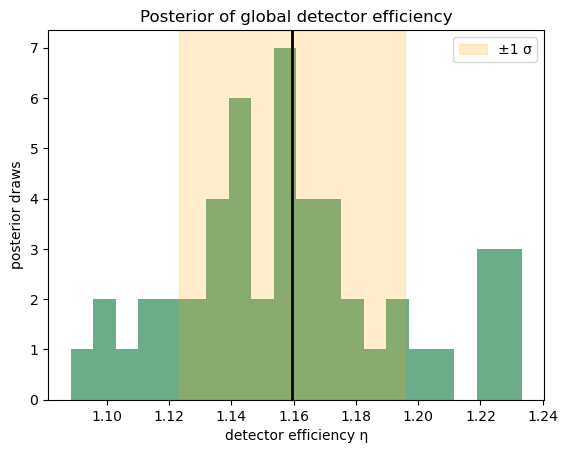

In [29]:
# mozemo pogledat i globalni slucaj (izjednaceno preko detektora)
T_optics = float(np.prod(q.optics.components["transmission"]))  # scalar

# draw-wise efficiency   η = 1 / (T_optics · invT)
eta_samples = 1.0 / (T_optics * global_samples)

eta_mean = eta_samples.mean().item()
eta_std = eta_samples.std().item()

print(f"Posterior efficiency η  = {eta_mean:.3f} ± {eta_std:.3f}")

plt.hist(eta_samples.cpu().numpy(), bins=20, alpha=0.7, color="seagreen")
plt.axvline(eta_mean, color="k", lw=2)
plt.axvspan(eta_mean - eta_std, eta_mean + eta_std, alpha=0.2, color="orange", label="±1 σ")
plt.xlabel("detector efficiency η")
plt.ylabel("posterior draws")
plt.title("Posterior of global detector efficiency")
plt.legend()
plt.show()
